## Lab 2
### Part 2: Dealing with overfitting

Today we work with [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) (*hint: it is available in `torchvision`*).

Your goal for today:
1. Train a FC (fully-connected) network that achieves >= 0.885 test accuracy.
2. Cause considerable overfitting by modifying the network (e.g. increasing the number of network parameters and/or layers) and demonstrate in in the appropriate way (e.g. plot loss and accurasy on train and validation set w.r.t. network complexity).
3. Try to deal with overfitting (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

__Please, write a small report describing your ideas, tries and achieved results in the end of this file.__

*Note*: Tasks 2 and 3 are interrelated, in task 3 your goal is to make the network from task 2 less prone to overfitting. Task 1 is independent from 2 and 3.

*Note 2*: We recomment to use Google Colab or other machine with GPU acceleration.

In [119]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchsummary
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os
import time


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

cuda:0


In [120]:
# Technical function
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print('Directory', path, 'is created!')
    else:
        print('Directory', path, 'already exists!')
        
root_path = 'fmnist'
mkdir(root_path)

Directory fmnist already exists!


In [121]:
download = True
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()
transforms.Compose((transforms.ToTensor()))


fmnist_dataset_train = torchvision.datasets.FashionMNIST(root_path, 
                                                        train=True, 
                                                        transform=train_transform,
                                                        target_transform=None,
                                                        download=download)
fmnist_dataset_test = torchvision.datasets.FashionMNIST(root_path, 
                                                       train=False, 
                                                       transform=test_transform,
                                                       target_transform=None,
                                                       download=download)

In [122]:
train_loader = torch.utils.data.DataLoader(fmnist_dataset_train, 
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)
test_loader = torch.utils.data.DataLoader(fmnist_dataset_test,
                                          batch_size=256,
                                          shuffle=False,
                                          num_workers=2)

In [123]:
len(fmnist_dataset_test)

10000

In [124]:
for img, label in train_loader:
    print(img.shape)
#     print(img)
    print(label.shape)
    print(label.size(0))
    break

torch.Size([128, 1, 28, 28])
torch.Size([128])
128


### Task 1
Train a network that achieves $\geq 0.885$ test accuracy. It's fine to use only Linear (`nn.Linear`) layers and activations/dropout/batchnorm. Convolutional layers might be a great use, but we will meet them a bit later.

In [125]:
class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes),
            nn.LogSoftmax(dim=1)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [126]:
torchsummary.summary(TinyNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 512]         401,920
              ReLU-3                  [-1, 512]               0
            Linear-4                  [-1, 256]         131,328
              ReLU-5                  [-1, 256]               0
            Linear-6                   [-1, 64]          16,448
              ReLU-7                   [-1, 64]               0
            Linear-8                   [-1, 32]           2,080
              ReLU-9                   [-1, 32]               0
           Linear-10                   [-1, 10]             330
       LogSoftmax-11                   [-1, 10]               0
Total params: 552,106
Trainable params: 552,106
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

Your experiments come here:

In [127]:
model = TinyNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_func = nn.CrossEntropyLoss()

In [128]:
losses = []
def train_model(model, train_loader, loss_fn, opt, n_epochs, lr_scheduler=None):
    for epoch in range(n_epochs):
        start_time = time.time()

        model.train(True) # enable dropout / batch_norm training behavior
        for X_batch, y_batch in train_loader:
            # move data to target device
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            # train on batch: compute loss, calc grads, perform optimizer step and zero the grads
            preds = model.forward(X_batch)
            loss = loss_fn(preds, y_batch)
            loss.backward()
            opt.step()
            opt.zero_grad()
            losses.append(loss.item())

            

        if lr_scheduler:
            lr_scheduler.step(loss)

        print(f'Epoch {epoch + 1} of {n_epochs} took {time.time() - start_time:.3f}s')
        

In [129]:
train_model(model, train_loader, loss_func, opt, n_epochs=12, lr_scheduler=lr_scheduler)

Epoch 1 of 12 took 5.619s
Epoch 2 of 12 took 5.661s
Epoch 3 of 12 took 5.534s
Epoch 4 of 12 took 5.458s
Epoch 5 of 12 took 5.327s
Epoch 6 of 12 took 5.324s
Epoch 7 of 12 took 5.422s
Epoch 8 of 12 took 5.517s
Epoch 9 of 12 took 5.394s
Epoch 10 of 12 took 5.475s
Epoch 11 of 12 took 5.483s
Epoch 12 of 12 took 5.439s


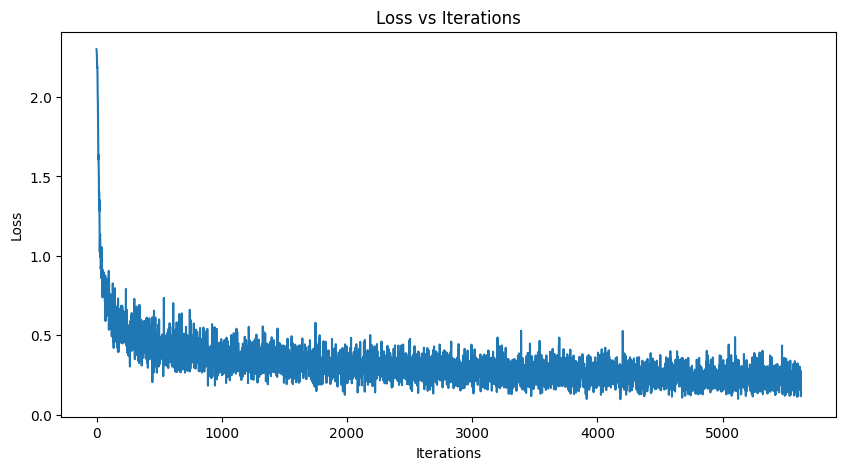

In [130]:
plt.figure(figsize=(10, 5))
plt.plot(losses)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss vs Iterations')
plt.show()

In [131]:
def test_model(model, test_loader):
    with torch.no_grad():
        model.eval()
        right_preds, total_preds = 0, 0
    
        for inputs, targets in test_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            preds = model(inputs)
            right_preds += torch.sum(preds.argmax(dim=1) == targets).item()
            total_preds += targets.size()[0]
            
    return right_preds / total_preds

In [132]:
test_acc = test_model(model, test_loader)
print("Test accuracy =", test_acc)

Test accuracy = 0.8884


### Task 2: Overfit it.
Build a network that will overfit to this dataset. Demonstrate the overfitting in the appropriate way (e.g. plot loss and accurasy on train and test set w.r.t. network complexity).

*Note:* you also might decrease the size of `train` dataset to enforce the overfitting and speed up the computations.

In [133]:
class OverfittingNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_shape, 50000), 
            nn.LeakyReLU(), 
            nn.Linear(50000, 10)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [134]:
torchsummary.summary(OverfittingNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                [-1, 50000]      39,250,000
         LeakyReLU-3                [-1, 50000]               0
            Linear-4                   [-1, 10]         500,010
Total params: 39,750,010
Trainable params: 39,750,010
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.77
Params size (MB): 151.63
Estimated Total Size (MB): 152.41
----------------------------------------------------------------


In [135]:
model = OverfittingNeuralNetwork().to(device)
opt = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(opt, patience=3)

Decrease the size of train dataset

In [136]:
fmnist_dataset_train_subset, _ = torch.utils.data.random_split(fmnist_dataset_train, [5000, 55000])

In [137]:
train_loader = torch.utils.data.DataLoader(fmnist_dataset_train_subset, 
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)
test_loader = torch.utils.data.DataLoader(fmnist_dataset_test,
                                          batch_size=256,
                                          shuffle=False,
                                          num_workers=2)
def plot_loss_and_acc(train_loss, test_loss, train_accuracy, test_accuracy):
  clear_output(wait=True)
  fig, axes = plt.subplots(1, 2, figsize=(15, 5))

  axes[0].set_title('Loss')
  axes[0].plot(train_loss, label='Train')
  axes[0].plot(test_loss, label='Test')
  axes[0].legend()
  axes[0].set_xlabel('Epoch')
  axes[0].set_ylabel('Loss')
  
  axes[1].set_title('Accuracy')
  axes[1].plot(train_accuracy, label='Train')
  axes[1].plot(test_accuracy, label='Test')
  axes[1].legend()
  axes[1].set_xlabel('Epoch')
  axes[1].set_ylabel('Accuracy')
  plt.show()



In [138]:
def train_model(model, train_loader, test_loader, loss_func, opt, n_epochs):
  train_loss = []
  test_loss = []
  train_accuracy = [] 
  test_accuracy = []
  # min_test_loss = np.Inf
  model.train()
  for epoch in tqdm(range(n_epochs)):
      run_loss = 0
      val_loss = 0

      epoch_train_accuracy = []
      epoch_test_accuracy = []

      for x_batch, y_batch in train_loader:
          opt.zero_grad()
          x_batch = x_batch.to(device)
          y_batch = y_batch.to(device)
          predictions = model(x_batch)
          loss = loss_func(predictions, y_batch)
          loss.backward()
          opt.step()

          run_loss += loss.item() * x_batch.size(0) 
          y_pred = predictions.max(1)[1].data
          epoch_train_accuracy.append(np.mean((y_batch.cpu() == y_pred.cpu()).numpy()))
          # accuracy = (predicts == labels).to(torch.float).mean() # another way
          # train_accuracies += [accuracy.item()] # another way
      # model.eval()
      # with torch.no_grad():
      for x_batch, y_batch in test_loader:
          x_batch = x_batch.to(device)
          y_batch = y_batch.to(device)
          predictions = model(x_batch)
          loss = loss_func(predictions, y_batch)

          val_loss += loss.item() * x_batch.size(0)
          y_pred = predictions.max(1)[1].data
          epoch_test_accuracy.append(np.mean((y_batch.cpu() == y_pred.cpu()).numpy()))

      run_loss = run_loss / len(train_loader.sampler)
      val_loss = val_loss / len(test_loader.sampler)
      train_loss.append(run_loss)
      test_loss.append(val_loss)

      test_accuracy.append(np.mean(epoch_test_accuracy))
      train_accuracy.append(np.mean(epoch_train_accuracy))

      # if test_loss <= min_test_loss:
      #   torch.save(model.state_dict(), 'model.pt')
      #   min_test_loss = test_loss
      
      plot_loss_and_acc(train_loss, test_loss, train_accuracy, test_accuracy)
  return train_loss, test_loss, train_accuracy, test_accuracy

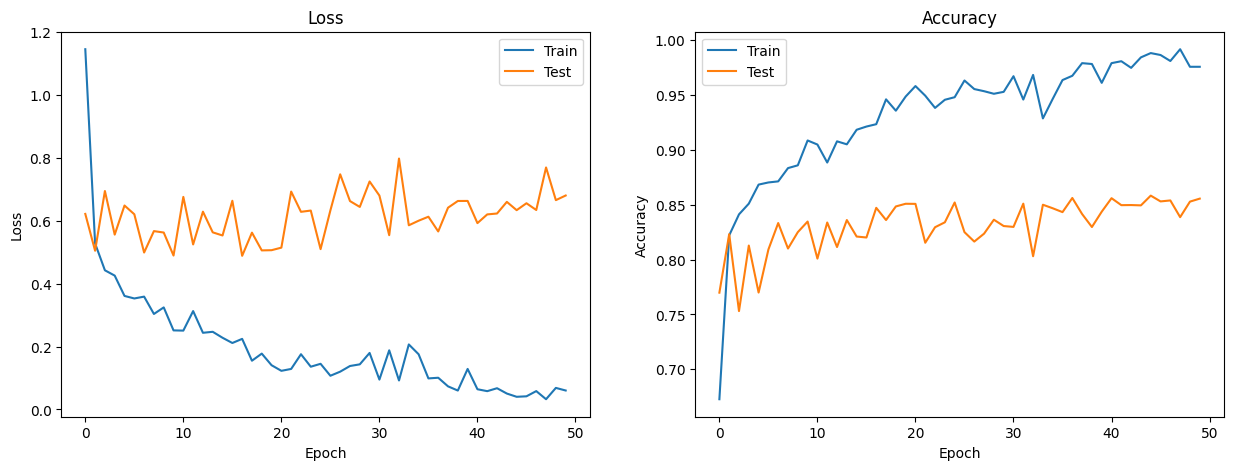

100%|██████████| 50/50 [06:02<00:00,  7.26s/it]

Wall time: 6min 3s


In [139]:
%%time
model = OverfittingNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_func = nn.CrossEntropyLoss()

n_epochs = 50
overfit_history = train_model(model, train_loader, test_loader, loss_func, opt, n_epochs)

As you can see as far as we increase the unmber of epochs, the loss for train decreases which seems to be a good thing, but when we run it on training data, we see it's npt working properly, exactly the same situation with accuracy

### Task 3: Fix it.
Fix the overfitted network from the previous step (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results. 

In [140]:
class FixedNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), 
            nn.Linear(input_shape, 50000), 
            nn.Dropout(p=0.7),
            nn.LeakyReLU(), 
            nn.Linear(50000, 10)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [141]:
torchsummary.summary(FixedNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                [-1, 50000]      39,250,000
           Dropout-3                [-1, 50000]               0
         LeakyReLU-4                [-1, 50000]               0
            Linear-5                   [-1, 10]         500,010
Total params: 39,750,010
Trainable params: 39,750,010
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 1.15
Params size (MB): 151.63
Estimated Total Size (MB): 152.79
----------------------------------------------------------------


In [142]:
model = FixedNeuralNetwork().to(device)
opt = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(opt, patience=3)

In [143]:
train_loss, train_acc, val_loss, val_acc = train_val_model(model, 
                                                      train_loader, 
                                                      test_loader, 
                                                      loss_func, 
                                                      opt, 
                                                      n_epochs=12, 
                                                      lr_scheduler=lr_scheduler)

Epoch 1 of 12 took 7.699s
Epoch 2 of 12 took 7.586s
Epoch 3 of 12 took 7.491s
Epoch 4 of 12 took 7.430s
Epoch 5 of 12 took 7.153s
Epoch 6 of 12 took 7.078s
Epoch 7 of 12 took 7.186s
Epoch 8 of 12 took 7.313s
Epoch 9 of 12 took 7.573s
Epoch 10 of 12 took 7.234s
Epoch 11 of 12 took 7.764s
Epoch 12 of 12 took 7.878s


In [144]:
colors = ('olivedrab', 'magenta')

def plot_training_results(train_data, val_data, ylabel="Loss value"):
    plt.figure(figsize=(12, 7))
    plt.plot(train_data, color=colors[0], label="Train")
    plt.plot(val_data, color=colors[1], label="Test")

    plt.title(f"{ylabel} during train/test")
    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.legend(fontsize=14)
    plt.show()

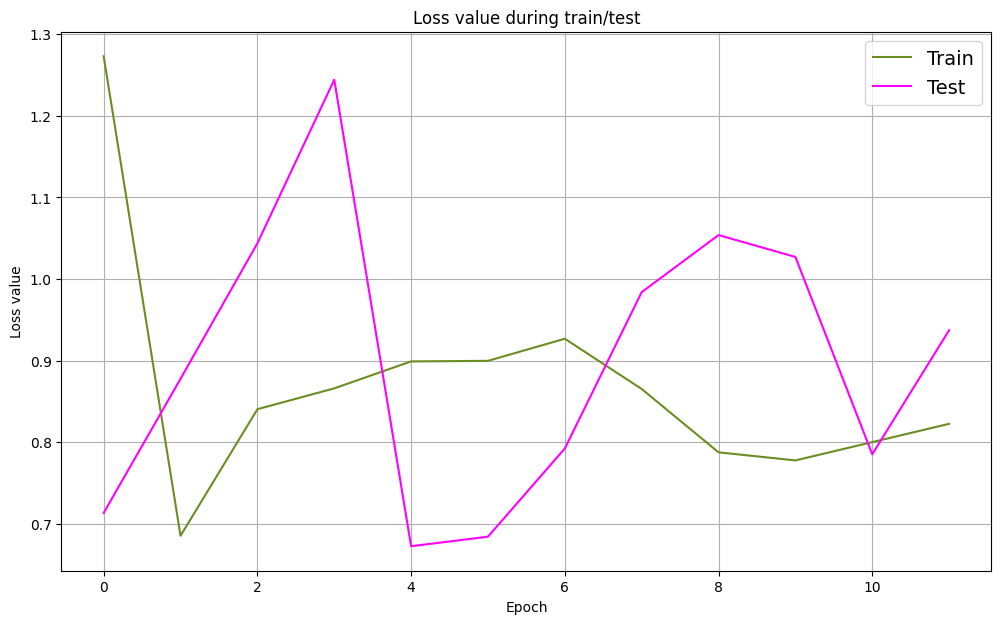

In [145]:
# Loss graphic
plot_training_results(train_loss, val_loss)

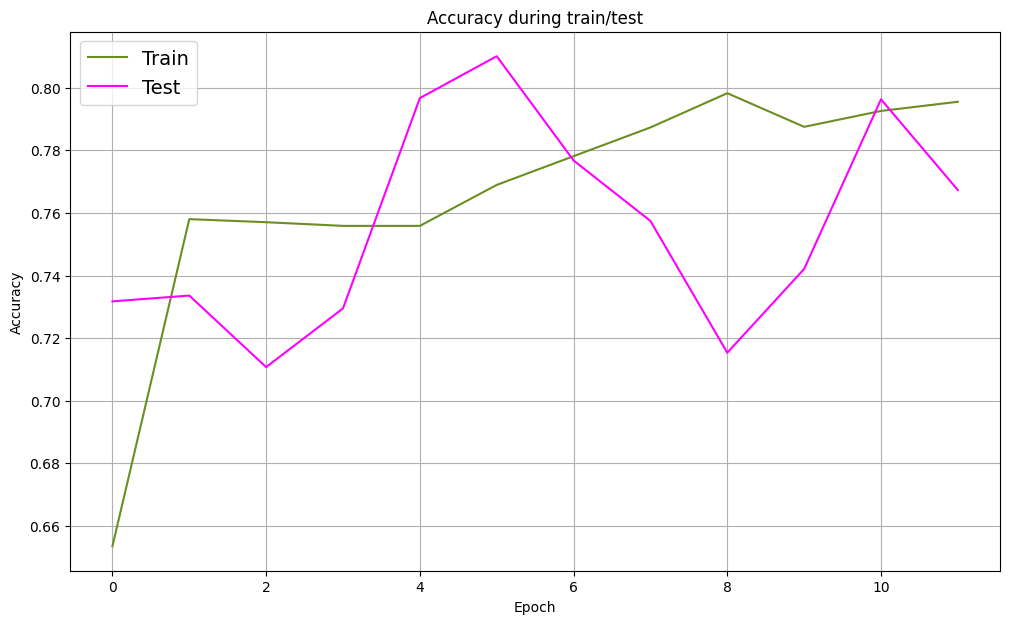

In [146]:
# Accuracy graphic
plot_training_results(train_acc, val_acc, ylabel="Accuracy")

**2) Batchnorm**

In [147]:
class FixedNeuralNetwork(nn.Module):   
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), 
            nn.Linear(input_shape, 50000), 
            nn.BatchNorm1d(50000),
            nn.LeakyReLU(), 
            nn.Linear(50000, 10)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [148]:
model = FixedNeuralNetwork().to(device)
opt = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(opt, patience=4)

In [149]:
train_loss, train_acc, val_loss, val_acc = train_val_model(model, 
                                                      train_loader, 
                                                      test_loader, 
                                                      loss_func, 
                                                      opt, 
                                                      n_epochs=12, 
                                                      lr_scheduler=lr_scheduler)

Epoch 1 of 12 took 7.997s
Epoch 2 of 12 took 8.285s
Epoch 3 of 12 took 7.884s
Epoch 4 of 12 took 7.653s
Epoch 5 of 12 took 8.560s
Epoch 6 of 12 took 7.634s
Epoch 7 of 12 took 8.202s
Epoch 8 of 12 took 8.293s
Epoch 9 of 12 took 8.087s
Epoch 10 of 12 took 7.571s
Epoch 11 of 12 took 8.040s
Epoch 12 of 12 took 9.104s


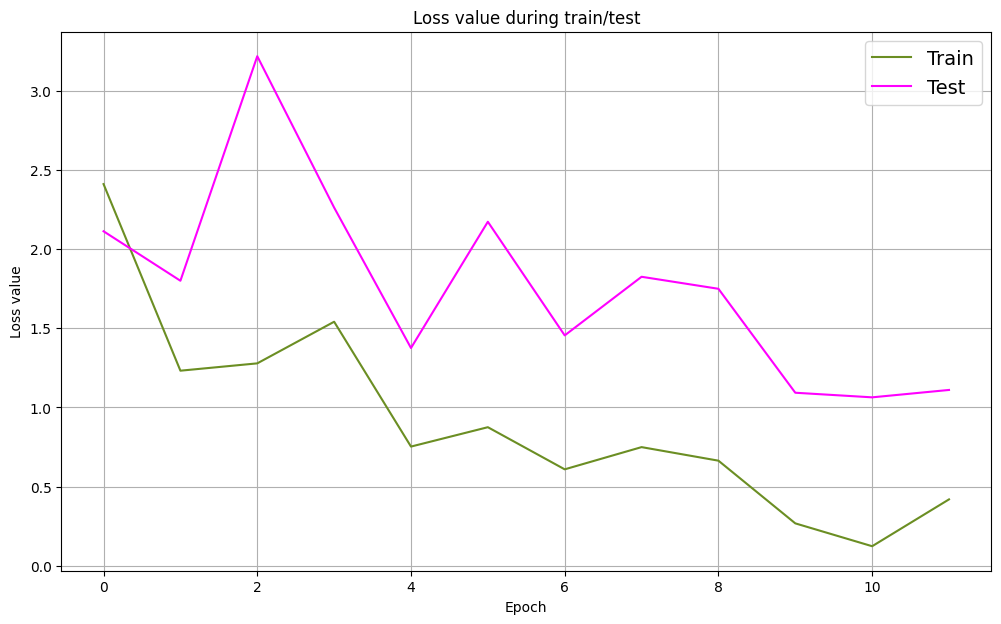

In [150]:
# Loss graphic
plot_training_results(train_loss, val_loss)

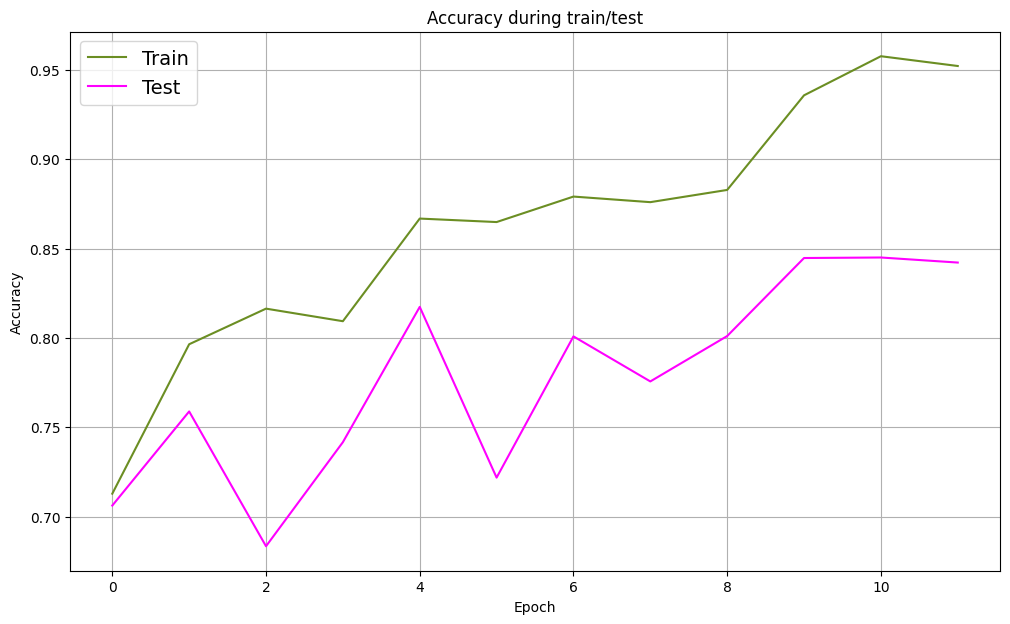

In [151]:
# Accuracy graphic
plot_training_results(train_acc, val_acc, ylabel="Accuracy")

### Conclusions:
We used `DropOut` and `BatchNormalisation` for dealing with overfitting

A) Dropout significantly lowered the effectiveness of retraining since the model did not adapt to the values of specific attributes because some neurons were "turned off" during model training.

B) BatchNormalization, on the other hand, was unable to address the issue of overfitting for our model because of the way in which its regularization effect is structured: this layer minimizes the internal covariate shift (change in the distribution of network parameters that takes place during training) and stabilizes the distribution of network parameters (namely, the mean and variance )

In the charts previously displayed, it is pretty clear that overfitting occurs as the epochs increase and the accuracy for train data decreases.
Since the accuracy in the fixed case remains near to the same numbers, we must have approached some sort of convergence point.
